# Этап 6: SVD Decomposition (Сингулярное разложение матриц)

SVD — это метод «хирургического» сжатия уже обученной модели. В отличие от LoRA, нам не нужно ничего дообучать: мы просто пересчитываем веса, чтобы они занимали меньше места.

## 1. Фундаментальная математика SVD

Любая матрица весов $W$ размера $M \times N$ (где $M$ — количество выходных нейронов, $N$ — входных) может быть разложена на три матрицы:
$$W = U \cdot \Sigma \cdot V^T$$

### Компоненты разложения:
1. **$U$ ($M \times M$)**: Левые сингулярные векторы (ортогональная матрица). Её столбцы — это «базовые выходные паттерны» нейронов.
2. **$\Sigma$ ($M \times N$)**: Диагональная матрица. На диагонали стоят **сингулярные числа** (Singular Values): $\sigma_1 \ge \sigma_2 \ge \dots \ge \sigma_{\min(M,N)} \ge 0$. 
   * *Физический смысл*: Число $\sigma_i$ показывает, сколько «энергии» или важной информации несет $i$-е измерение в данных. 
3. **$V^T$ ($N \times N$)**: Правые сингулярные векторы (ортогональная матрица). Её строки — это «базовые входные признаки».

--- 

## 2. Low-Rank Approximation (Сжатие)

Основная идея компрессии заключается в том, что большинство матриц в нейросетях имеют **низкий эффективный ранг**. Это значит, что первые несколько сингулярных чисел ($\sigma$) очень большие, а остальные стремятся к нулю.

Мы выбираем ранг $k \ll \min(M,N)$ и отбрасываем все значения после $k$-го. Получаем приближенную матрицу:
$$W \approx W_k = U_k \cdot \Sigma_k \cdot V_k^T$$

Согласно **теореме Эккарта-Янга**, $W_k$ является наилучшим возможным приближением матрицы $W$ ранга $k$ (в смысле нормы Фробениуса).

## 3. Превращение в два линейных слоя

Чтобы получить реальное ускорение и экономию, мы не перемножаем $U_k, \Sigma_k$ и $V_k^T$ обратно. Вместо этого мы создаем два последовательных слоя:

1. **Матрица A (входная)**: $A = \sqrt{\Sigma_k} \cdot V_k^T$. Размер: $k \times N$.
2. **Матрица B (выходная)**: $B = U_k \cdot \sqrt{\Sigma_k}$. Размер: $M \times k$.

Теперь операция $y = Wx + b$ превращается в:
$$y = (B \cdot (A \cdot x)) + b$$

### Экономия параметров:
* **Было**: $M \cdot N$
* **Стало**: $k \cdot N + k \cdot M = k(N + M)$

*Пример*: Слой $1024 \times 1024$ при ранге $k=64$ сжимается в:
$$\frac{1024 \cdot 1024}{64 \cdot (1024 + 1024)} = \frac{1048576}{131072} = 8\text{x}$$


In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from src.model import GPTLanguageModel, device, estimate_loss, decode, encode
import copy

# 1. Загружаем оригинал
model = GPTLanguageModel().to(device)
model.load_state_dict(torch.load('model_ckpt.pt', map_location=device))
model.eval()

def get_val_loss(mdl):
    with torch.no_grad():
        return estimate_loss(mdl)['val'].item()

baseline_loss = get_val_loss(model)
print(f"Baseline Loss (FP32): {baseline_loss:.4f}")

/Users/vladmac/Code/ML-Colab/Andrey Karpathy Lessons/Lesson 2. LLMCompression/src/model.py:86: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  Формула: $Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$


Using device: mps
Baseline Loss (FP32): 1.5130


## 4. Спектральный анализ сингулярных чисел
Давайте визуализируем, сколько информации мы теряем при выборе разного ранга.

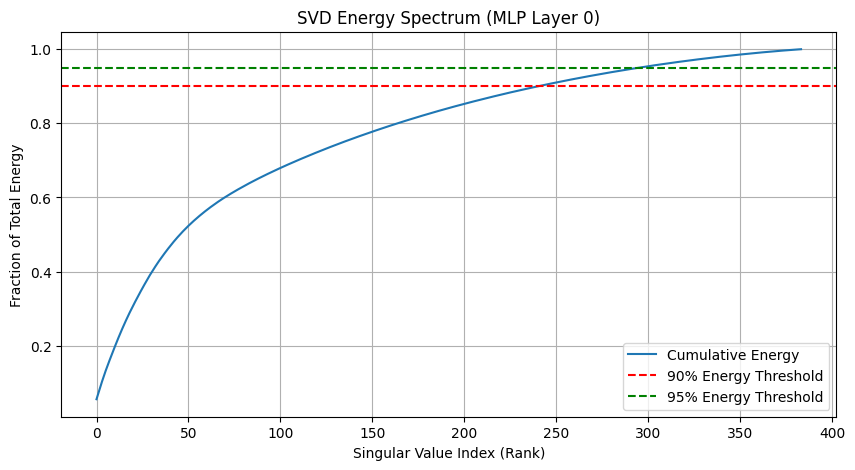

Ранг оригинальной матрицы: 384
Ранг для сохранения 95% энергии: 295 (Сжатие ~1.3x)


In [5]:
# Возьмем первый MLP слой первого блока
W = model.blocks[0].ffwd.net[0].weight.data.cpu()
U, S, Vh = torch.linalg.svd(W, full_matrices=False)

# Считаем кумулятивное сохранение энергии (энергия = квадрат сингулярного числа)
s_squared = S**2
energy_cumulative = torch.cumsum(s_squared, dim=0) / torch.sum(s_squared)

plt.figure(figsize=(10, 5))
plt.plot(energy_cumulative.numpy(), label='Cumulative Energy')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Energy Threshold')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Energy Threshold')
plt.title("SVD Energy Spectrum (MLP Layer 0)")
plt.xlabel("Singular Value Index (Rank)")
plt.ylabel("Fraction of Total Energy")
plt.legend()
plt.grid(True)
plt.show()

k_95 = (energy_cumulative < 0.95).sum().item()
print(f"Ранг оригинальной матрицы: {len(S)}")
print(f"Ранг для сохранения 95% энергии: {k_95} (Сжатие ~{len(S)/k_95:.1f}x)")

## 5. Реализация SVD сжатия
Теперь мы применим выбранный ранк ко всей модели.

In [ ]:
class SVDLinear(nn.Module):
    def __init__(self, original_linear, rank):
        super().__init__()
        W = original_linear.weight.data.cpu() # Уходим на CPU для SVD (предотвращаем Warning)
        bias = original_linear.bias
        
        U, S, Vh = torch.linalg.svd(W, full_matrices=False)
        
        U_reduced = U[:, :rank]
        S_reduced = S[:rank]
        Vh_reduced = Vh[:rank, :]
        
        S_sqrt = torch.diag(torch.sqrt(S_reduced))
        
        # Возвращаем параметры на целевое устройство
        self.A = nn.Linear(original_linear.in_features, rank, bias=False).to(device)
        self.B = nn.Linear(rank, original_linear.out_features, bias=(bias is not None)).to(device)
        
        self.A.weight.data = (S_sqrt @ Vh_reduced).to(device)
        self.B.weight.data = (U_reduced @ S_sqrt).to(device)
        if bias is not None:
            self.B.bias.data = bias.data.to(device)

    def forward(self, x):
        return self.B(self.A(x))

def apply_svd_compression(model, rank=256):
    for block in model.blocks:
        block.ffwd.net[0] = SVDLinear(block.ffwd.net[0], rank=rank)
        block.ffwd.net[2] = SVDLinear(block.ffwd.net[2], rank=rank)
    return model

model_svd = copy.deepcopy(model)
model_svd = apply_svd_compression(model_svd, rank=64)

new_loss = get_val_loss(model_svd)
print(f"\nLoss после SVD (rank=64): {new_loss:.4f}")
print(f"Деградация Loss: {new_loss - baseline_loss:.4f}")


Loss после SVD (rank=64): 1.9458
Деградация Loss: 0.4328


### 6. Анализ экономии и финальный тест

In [8]:
def count_params(mdl):
    return sum(p.numel() for p in mdl.parameters())

p_orig = count_params(model)
p_svd = count_params(model_svd)

print(f"Параметры (Original): {p_orig:,}")
print(f"Параметры (SVD):      {p_svd:,}")
print(f"Коэффициент сжатия:   {p_orig/p_svd:.2f}x")

print("\n--- [Original Generated Output] ---")
context = torch.tensor(encode("ROMEO: "), dtype=torch.long, device=device).unsqueeze(0)
print("ROMEO: ", end='', flush=True)
#print(decode(model_svd.generate(context, max_new_tokens=500)[0].tolist()))

for token in model.generate_stream(context, max_new_tokens=4000):
    print(decode([token]), end='', flush=True)

print("\n--- [SVD Generated Output] ---")
context = torch.tensor(encode("ROMEO: "), dtype=torch.long, device=device).unsqueeze(0)
print("ROMEO: ", end='', flush=True)
#print(decode(model_svd.generate(context, max_new_tokens=500)[0].tolist()))

for token in model_svd.generate_stream(context, max_new_tokens=4000):
    print(decode([token]), end='', flush=True)

Параметры (Original): 10,788,929
Параметры (SVD):      5,185,601
Коэффициент сжатия:   2.08x

--- [Original Generated Output] ---
ROMEO: my looks lord, or either to death,
Than we will hedily most to be allerence,
In invised amient. Of what an his night,
Is't pupon to mine when thou call remain,
Fortuel.

CORIOLANUS:
Come shalt I not; I think she is fear too behold
And a witcration of a petward in otherit
To'thon their ownder's hand way and that 'twould
With not pleaden's, fair to this old help; and thanks,
And he taste love statution their from hereat person.
But shall very hence them on the pleasury, with her loss
And so nothing and prevail's tombitress whose we have
no moest unlightsoad: then is the now of this Rive:
Longs after'd so neither--house at a fire
Give senation, and lead before in enjoy'd
In thine ambities; apmnens for be colour's right.
Look'st thou agaven to my husband and can lield,
And tell my Romeo servele in the wind me skisstruce
As thou hast spurs are behind mine 